<a href="https://colab.research.google.com/github/josephDeMat/CMM307-Coursewor-Comparative_Eval/blob/main/Comparative_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JOSEPH DE MATHIA 2013786 | CMM307 |

## IMDB Movie Reviews Dataset

The IMDB movie reviews dataset contains 50,000 reviews labeled as either positive or negative. The dataset consists of two columns: **`review`** and **`sentiment`**.

### Dataset Overview
- The dataset containes no null values.
- Originally, the dataset contained **486 duplicate rows**, I later removed them to avoid over-representing words in those reviews.
- The dataset is evenly split between **positive** and **negative** reviews, with **25,000 in each category** therefore the model is not at of biased
- Most reviews range from **0 to 500 words**, with only a few exceeding **1,000 words**.

These details are illustrated in the following code section.

### Project Goal
This dataset is ideal for training a text classification algorithm with the idea of performing sentiment analysis on future reviews to determine if they are positive or negative.

For this project, I will train two classification algorithms:
1. **K-Nearest Neighbors (KNN)**
2. **Multi-Layer Perceptron (MLP)**

I will aslo be exmplaining and recreating

### Dataset Source
The dataset was sourced from Kaggle and can be found at the following link:  
[IMDB Dataset on Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)


In [42]:
import numpy as np
import pandas as pd
import io
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

print("Please upload the IMDb dataset (e.g., 'imdb_labelled.txt')...")
uploaded = files.upload()

csv_file = io.BytesIO(uploaded[list(uploaded.keys())[0]])
df = pd.read_csv(csv_file)


Please upload the IMDb dataset (e.g., 'imdb_labelled.txt')...


Saving IMDB Dataset.csv to IMDB Dataset (4).csv


checking out the dataset to make sure that it contains no null values, get a genral idea of it's structure and replace lables with int values


Dataset Preview:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Missing Values in Each Column:
review       0
sentiment    0
dtype: int64

Unique Types in the 'review' Column:
review
<class 'str'>    50000
Name: count, dtype: int64

Sentiment Value Counts:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Conv

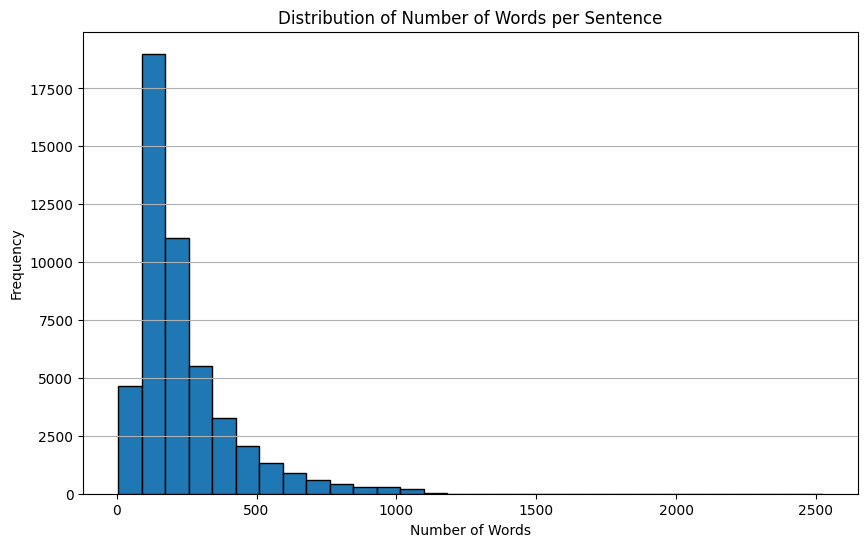

In [45]:
import matplotlib.pyplot as plt
from collections import Counter


print("\nDataset Preview:")
print(df.head())

print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# review "review " column
print("\nUnique Types in the 'review' Column:")
if 'review' in df.columns:
    print(df['review'].apply(type).value_counts())

# review the sentiment column and convert to binary
if 'sentiment' in df.columns:
    print("\nSentiment Value Counts:")
    print(df['sentiment'].value_counts())
    if not pd.api.types.is_numeric_dtype(df['sentiment']):
        print("\nConverting sentiment values to binary...")
        df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


#Check for duplicate rows and remove
print("\nDuplicate Rows Count:")
print(df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicate Rows Count:")
print(df.duplicated().sum())

#Display basic statistics for the dataset
print("\nBasic Statistics for Numeric Columns:")
print(df.describe())

# Function to tokenize for ease of uss when word counting
def tokenize_and_process(data):
    all_words = []
    sentence_lengths = []
    for sentence in data:
        tokens = re.findall(r'\b\w+\b', sentence.lower())
        all_words.extend(tokens)
        sentence_lengths.append(len(tokens))
    return all_words, sentence_lengths


# Display the top 20 most common words
all_words, sentence_lengths = tokenize_and_process(df['review'])
word_counts = Counter(all_words)
top_20_words = word_counts.most_common(20)
print("Top 20 Most Common Words:")
for word, count in top_20_words:
    print(f"{word}: {count}")

# Plot word count distribution
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, edgecolor='black')
plt.title("Distribution of Number of Words per Sentence")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

Pre-Processing

In [51]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define the preprocessing function
def preprocess_text(data):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    processed_data = []
    for sentence in data:
        tokens = word_tokenize(sentence)
        filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token not in stop_words]
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        processed_data.append(" ".join(lemmatized_tokens))
    return processed_data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



## Representation Learning and Algorithms

### Representation Learning

For representation learning, I utilized TF-IDF (Term Frequency-Inverse Document Frequency) to convert textual data into numerical feature vectors. TF-IDF transforms each word into a feature associated with a weight that represents its importance in the document. I limited the vector to a maximum of the 2,000 most significant words. While this value could be higher, I constrained it to 2,000 due to training time constraints. Words appearing in fewer than five documents or in over 80% of documents were excluded, as they are likely to introduce noise or be irrelevant to the outcome.

I set the parameter `ngram_range=(1,2)` to include both unigrams and bigrams. This approach is particularly effective for algorithms like KNN, as it assigns higher importance to significant words in both positive and negative reviews. By clustering similar words together, TF-IDF makes it easier for KNN to differentiate between positive and negative sentiment.

### K-Nearest Neighbors (KNN)

KNN is an instance-based learning algorithm that predicts outcomes by comparing the similarity of new data points with those in the training dataset. Unlike other models, KNN does not involve pre-training; instead, it calculates predictions dynamically based on the training data.

KNN works as follows:  
KNN measures the similarity between the new data point and all historical data points. The historical data points are ranked based on similarity, and the top K nearest neighbors are selected (typically an odd number to avoid ties). A "vote" occurs, and the predicted outcome is determined. The vote can occur with every neighbor carrying the same weight or with weighted importance given to the "best" neighbors.

After hyperparameter tuning using GridSearchCV, I identified the optimal parameters for KNN:

- **Accuracy Before Hyperparameter Tuning**: `0.7144`
- **Best Hyperparameters**: `{'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}`
- **Best Accuracy**: `0.7254`

I could have run hyperparameter tuning for longer, going through many more parameter values but observing the marginal performance gain above this is unlikely to improve the algorithm by much. This indicates that KNN might not be the best algorithm for text classification in this instance.


KNN

In [36]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import nltk

nltk.download('punkt_tab')

x = df['review'].values
y = df['sentiment'].values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xnp = np.array(x)
ynp = np.array(y)
acc_score = []
F1_score = []

for train_index, test_index in kf.split(xnp, ynp):
    # Split the data
    x_train, x_test = xnp[train_index], xnp[test_index]
    y_train, y_test = ynp[train_index], ynp[test_index]

    # Preprocess the training and test sets
    x_train = preprocess_text(x_train)
    x_test = preprocess_text(x_test)

    # Apply TF-IDF Transformation
    tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.8, ngram_range=(1, 2))
    x_train_tfidf = tfidf.fit_transform(x_train)
    x_test_tfidf = tfidf.transform(x_test)

    # Train KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=5, metric='cosine',)
    knn.fit(x_train_tfidf, y_train)

    # Predict on test data
    y_pred = knn.predict(x_test_tfidf)

    # Evaluate accuracy
    acc = accuracy_score(y_test, y_pred)
    acc_score.append(acc)
    print(f"Fold Accuracy: {acc}")

    #evalueate f1 score
    f1 = f1_score(y_test, y_pred)
    F1_score.append(f1)
    print(f"Fold F1-Score: {f1}")

# Print average F1 and accuracy across all folds
KNN_average_F1 = np.mean(F1_score)
KNN_average_accuracy = np.mean(acc_score);
print("Average Accuracy:", KNN_average_accuracy)
print("Average F1_Score:",KNN_average_F1 )

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Fold Accuracy: 0.7132197237067661
Fold F1-Score: 0.7124949454104327
Fold Accuracy: 0.7109004739336493
Fold F1-Score: 0.7048285802532688
Fold Accuracy: 0.7179306171843485
Fold F1-Score: 0.7232063334982682
Fold Accuracy: 0.7115772488906817
Fold F1-Score: 0.7111694607150071
Fold Accuracy: 0.7185356998789835
Fold F1-Score: 0.7156972598553529
Average Accuracy: 0.7144327527188858
Average F1_Score: 0.713479315946466


#### Hyper parameter tuning for KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
import numpy as np
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

x = df['review'].values
y = df['sentiment'].values

# Preprocess the text data
x_processed = preprocess_text(x)

# TF-IDF Transformation
tfidf = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.8, ngram_range=(1, 2))
x_tfidf = tfidf.fit_transform(x_processed)

# Define KNN and Parameter Grid
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [5, 7, 9],
    'metric': ['manhattan', 'cosine'],
    'weights': ['uniform', 'distance']
}

# Use GridSearchCV for hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1

# Perform grid search
grid_search.fit(x_tfidf, y)

# Best hyperparameters and accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Hyperparameters: {'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Best Accuracy: 0.7254246530999551


### MLP
## Multi-Layer Perceptron (MLP)

MLP (Multi-Layer Perceptron) is a type of neural network designed for classification tasks, comprising an input layer, hidden layers, and an output layer. The input layer corresponds to the number of input features, which in this case consists of 2,000 neurons derived from the reduced feature set created by the TF-IDF vectorizer. This decision reflects a compromise between model complexity and the constraints of training time and computational resources.

For the hidden layers, I used two layers with 128 neurons each, employing the ReLU (Rectified Linear Unit) activation function to facilitate effective learning of non-linear patterns in the data. The output layer uses a sigmoid activation function to generate binary classification results, distinguishing between positive and negative sentiment.

During hyperparameter tuning, I tested several of the model’s parameters to optimize its performance. However, due to time and computational constraints, I was unable to explore a broader range of hyperparameter options. It is likely that further exploration and tuning of additional parameters could slightly improve the model's performance.

Using GridSearchCV, I identified the optimal parameters for the MLP model within the limitations of the available resources:
- **Accuracy without Parameter hypertuning** `0.8556`
- **Best Hyperparameters**: `{'batch_size': 128, 'epochs': 20, 'model__num_hidden_units': 256}`
- **Best Accuracy**: `0.8689`


In [37]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

feature_num = 2000

def create_mlp(input_dim):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_dim,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    return model


x = df['review'].values
y = df['sentiment'].values


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xnp = np.array(x)
ynp = np.array(y).astype('float32')
acc_score = []
f1_scores = []

for train_index, test_index in kf.split(xnp, ynp):
    # Split the data
    x_train, x_test = xnp[train_index], xnp[test_index]
    y_train, y_test = ynp[train_index], ynp[test_index]

    # Preprocess the training and test sets
    x_train = preprocess_text(x_train)
    x_test = preprocess_text(x_test)

    # Apply TF-IDF Transformation
    tfidf = TfidfVectorizer(max_features=feature_num, min_df=5, max_df=0.8, ngram_range=(1, 2))
    x_train_tfidf = tfidf.fit_transform(x_train).todense()
    x_test_tfidf = tfidf.transform(x_test).todense()

    # Create the MLP model
    model = create_mlp(input_dim=x_train_tfidf.shape[1])

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )

    # Train the model
    model.fit(
        x_train_tfidf, y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping]
    )

    test_results = model.evaluate(x_test_tfidf, y_test, verbose=1)

    # Generate predictions for the test set
    y_pred = model.predict(x_test_tfidf)
    y_pred = (y_pred > 0.5).astype('int32')

    # Compute F1-Score and Accuracy
    acc_score.append(test_results[1])
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Print the average accuracy and f1 score across all folds
MLP_average_F1 = np.mean(f1_scores)
MLP_average_accuracy = np.mean(acc_score)
print("Average Accuracy:", np.mean(acc_score))
print("Average F1_Score:", MLP_average_F1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7612 - loss: 0.4846 - val_accuracy: 0.6871 - val_loss: 0.5599
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9272 - loss: 0.1933 - val_accuracy: 0.8078 - val_loss: 0.4103
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9726 - loss: 0.1069 - val_accuracy: 0.8553 - val_loss: 0.3472
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9953 - loss: 0.0442 - val_accuracy: 0.8549 - val_loss: 0.4198
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9993 - loss: 0.0164 - val_accuracy: 0.8557 - val_loss: 0.4881
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.8545 - val_loss: 0.5386
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8525 - loss: 0.3496
Test results - Loss: 0.3481579124927521 - Accuracy: 0.8540889620780945
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7691 - loss: 0.4745 - val_accuracy: 0.7382 - val_loss: 0.5535
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9338 - loss: 0.1832 - val_accuracy: 0.8335 - val_loss: 0.3863
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9768 - loss: 0.0974 - val_accuracy: 0.8461 - val_loss: 0.3596
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9950 - loss: 0.0411 - val_accuracy: 0.8508 - val_loss: 0.4260
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9994 - loss: 0.0152 - val_accuracy: 0.8533 - val_loss: 0.4808
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9999 - loss: 0.0061 - val_accuracy: 0.8534 - val_loss: 0.5225
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8570 - loss: 0.3345
Test results - Loss: 0.3445099890232086 - Accuracy: 0.8559039831161499
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7511 - loss: 0.4992 - val_accuracy: 0.5179 - val_loss: 0.6410
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9306 - loss: 0.1903 - val_accuracy: 0.7565 - val_loss: 0.4692
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9742 - loss: 0.1011 - val_accuracy: 0.8511 - val_loss: 0.3591
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9950 - loss: 0.0419 - val_accuracy: 0.8563 - val_loss: 0.4284
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9994 - loss: 0.0166 - val_accuracy: 0.8549 - val_loss: 0.4899
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.8528 - val_loss: 0.5360
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8622 - loss: 0.3268
Test results - Loss: 0.34097421169281006 - Accuracy: 0.8547801375389099
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7599 - loss: 0.4874 - val_accuracy: 0.8166 - val_loss: 0.5435
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9300 - loss: 0.1880 - val_accuracy: 0.8532 - val_loss: 0.3709
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9717 - loss: 0.1093 - val_accuracy: 0.8563 - val_loss: 0.3473
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9931 - loss: 0.0451 - val_accuracy: 0.8535 - val_loss: 0.4055
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9994 - loss: 0.0172 - val_accuracy: 0.8528 - val_loss: 0.4736
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8548 - val_loss: 0.5112
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8584 - loss: 0.3422
Test results - Loss: 0.35143521428108215 - Accuracy: 0.8562928438186646
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.7627 - loss: 0.4814 - val_accuracy: 0.8553 - val_loss: 0.5328
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9300 - loss: 0.1917 - val_accuracy: 0.8593 - val_loss: 0.3612
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9724 - loss: 0.1067 - val_accuracy: 0.8554 - val_loss: 0.3406
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9946 - loss: 0.0435 - val_accuracy: 0.8533 - val_loss: 0.4269
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9996 - loss: 0.0149 - val_accuracy: 0.8591 - val_loss: 0.4755
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 1.0000 - loss: 0.0061 - val_accuracy: 0.8591 - val_loss: 0.5216
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8529 - loss: 0.3501
Test results - Loss: 0.34119170904159546 - Accuracy: 0.8572005033493042
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Average Accuracy: 0.8556532859802246



#### Hyper parameter tuning for MLP

In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import nltk

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

feature_num = 2000

# Define the MLP model
def create_and_compile_mlp(input_dim, num_hidden_units=128, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    # First hidden layer
    model.add(Dense(num_hidden_units, input_shape=(input_dim,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    # Second hidden layer
    model.add(Dense(num_hidden_units, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    #compile model in same func to use with grid seasrch
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

mlp = KerasClassifier(
   model=create_and_compile_mlp,
    input_dim=feature_num,
    num_hidden_units=128,
    dropout_rate=0.5,
    epochs=10,
    batch_size=128,
    verbose=1,
)

# Define parameter grid for hyperparameter tuning
param_grid = {
    "model__num_hidden_units": [128, 256],
    "batch_size": [128, 256],
    "epochs": [10, 20]
}

# Preprocess and transform data
x = df['review'].values
y = df['sentiment'].values
x_processed = preprocess_text(x)

# Apply TF-IDF transformation
tfidf = TfidfVectorizer(max_features=feature_num, min_df=5, max_df=0.8, ngram_range=(1, 2))
x_tfidf = tfidf.fit_transform(x_processed).todense()
x_tfidf = np.asarray(x_tfidf)

# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# Perform grid search
grid_search.fit(x_tfidf, y)

# Output the best parameters and accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7703 - loss: 0.5253
Epoch 2/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8786 - loss: 0.2872
Epoch 3/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8898 - loss: 0.2648
Epoch 4/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9117 - loss: 0.2225
Epoch 5/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9267 - loss: 0.1815
Epoch 6/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9420 - loss: 0.1472
Epoch 7/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9562 - loss: 0.1139
Epoch 8/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9643 - loss: 0.0916
Epoch 9/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9713 - loss: 0.0778
Epoch 10/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9740 - loss: 0.0701
Epoch 11/20
388/388 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9784 - loss: 0.0592
Epoch 12/20
388/388 ━━━━━━━━━━━━━━━━━━

## Evaluation

The KNN model performs comparatively worse than the MLP model both in accuracy and F1 scores.

This illustrates tha MLP is an algorithm that is much better suited for text classification for this type of dataset.

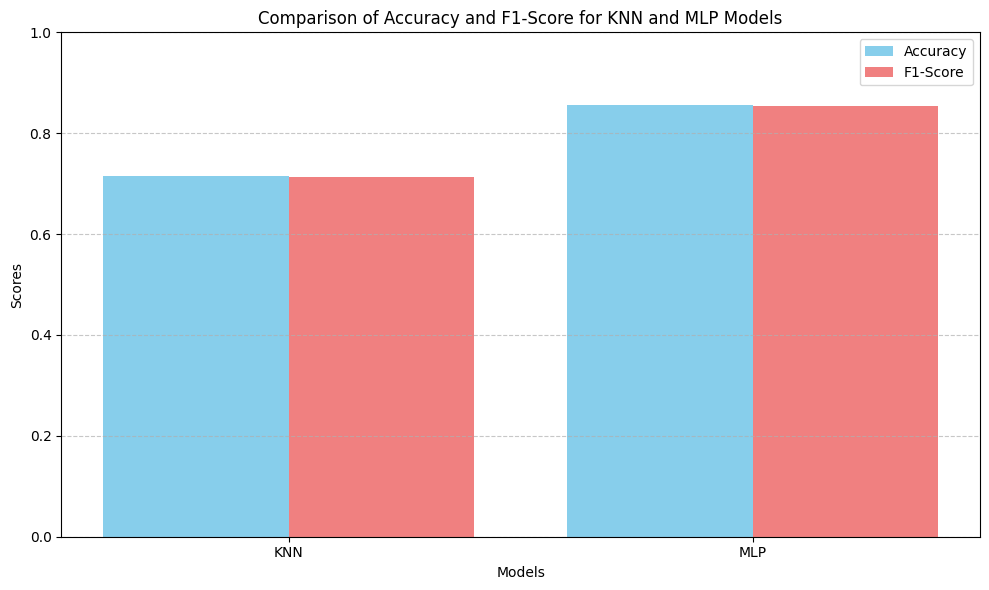

In [38]:
import matplotlib.pyplot as plt
import numpy as np

models = ["KNN", "MLP"]
accuracy_scores = [KNN_average_accuracy, MLP_average_accuracy]
f1_scores = [KNN_average_F1, MLP_average_F1]
x = np.arange(len(models))
width = 0.4

# Plot Accuracy and F1-Score
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, f1_scores, width, label='F1-Score', color='lightcoral')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Accuracy and F1-Score for KNN and MLP Models')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# STUDY RECREATION

paper can be found at [Papers with code paper](https://paperswithcode.com/paper/fast-and-accurate-sentiment-classification)


## Paper Study

The paper explores the use of the Naive Bayes (NB) model for text sentiment analysis tasks, emphasizing its faster training times compared to other commonly used models, such as SVM. The paper highlights several techniques to improve the accuracy of the NB model, achieving a reported accuracy of 88% on the IMDB movie reviews dataset.

Unlike the approach in the paper, I did not split the dataset into two 25,000 sections for training and testing.

### Handling Negations

The paper identifies a key challenge with single-word features in sentences like "not good," where the sentiment might be misinterpreted as both positive and negative. To address this, the authors propose an algorithm (with pseudocode provided) that transforms words following a negation (e.g., "not" or "n’t") into a combined feature like "not_good." This approach uses a negation state variable, which marks words as negated by appending "not_" to them. The state resets when encountering punctuation or double negations. I implemented this algorithm in my code to replicate the paper's results.

### N-Grams

The authors extract unigrams, bigrams, and trigrams but avoid higher-order n-grams (e.g., 4-grams) to prevent overfitting. Similarly, I used the CountVectorizer to extract unigrams, bigrams, and trigrams while limiting the maximum number of features. I ensured the feature space was capped at 32,000. The reasoning for this choice is explained in the next section.

### Feature Selection

For feature selection, the paper emphasizes the importance of reducing the dimensionality of the feature space to improve performance. While introducing higher-dimensional features like bigrams and trigrams can increase model capacity, it also significantly inflates the number of features. To manage this, the paper removes features that appear only once and applies mutual information to further reduce the feature set.

Due to time and computational constraints, I did not follow the same approach. Instead, I capped the number of features at 32,000 in the CountVectorizer function. This approach limits the features to the 32,000 most frequent n-grams rather than using mutual information as in the paper.

### Naive Bayes Classifier and Laplacian Smoothing

The paper employs a Naive Bayes classifier with Laplacian smoothing to enhance performance. For my implementation, I used the Bernoulli Naive Bayes classifier, as recommended in the paper. In scikit-learn's `BernoulliNB` implementation, Laplacian smoothing is handled automatically by the `alpha` parameter. This parameter adjusts probabilities for unseen features, ensuring the model generalizes well. My implementation mirrors the paper's methodology to ensure alignment with their results.

### Conclusion
The algorithm I re-created following the paper does not apply feature selection (due to time and computational constraints), unlike the paper's implementation. However, my implementation outperforms the paper's algorithm when both are run without feature selection. Specifically, the accuracy of my implementation is 87.44%, compared to the paper's 85.20%. This discrepancy is likely due to the data split; the paper splits the dataset into a training set of 25,000 and a test set of 25,000, whereas I used a different approach.


In [50]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
nltk.download('punkt')

# Define the preprocessing function slightly different from one above
def preprocess_text(data):
    stop_words = set(stopwords.words('english')) - {'not', 'but', 'no'}
    lemmatizer = WordNetLemmatizer()

    processed_data = []
    for sentence in data:
        tokens = word_tokenize(sentence)
        filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token not in stop_words]
        processed_data.append(" ".join(filtered_tokens))
    return processed_data


## Negation Handling
def handle_negation(text):
    words = text.split()
    negated = False
    processed_words = []

    for word in words:
        if negated:
            processed_words.append(f"not_{word}")
            negated = False
        elif word in ["not", "n't"]:
            negated = True
        else:
            processed_words.append(word)

    return " ".join(processed_words)

##Train Bernoulli Naive Bayes
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

#without this I got bug
X = np.array(df['review'])
y = np.array(df['sentiment'])

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply negation handling to each sentence in the dataset
    x_train = [handle_negation(sentence) for sentence in X_train]
    x_test = [handle_negation(sentence) for sentence in X_test]

    # Preprocess text (tokenization, stopwords removal)
    x_train = preprocess_text(x_train)
    x_test = preprocess_text(x_test)

    # Vectorize the text data
    vectorizer = CountVectorizer(ngram_range=(1, 3), binary=True, max_features=32000)
    X_train_vect = vectorizer.fit_transform(x_train)
    X_test_vect = vectorizer.transform(x_test)

    # Train Bernoulli Naive Bayes
    model = BernoulliNB()
    model.fit(X_train_vect, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test_vect)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Final accuracy
print(f"Average Accuracy: {np.mean(accuracies) * 100:.2f}%")






[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average Accuracy: 87.44%
